In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [5]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
421,2,94,68,18,76,26.0,0.561,21,0


# Step 0. Binarize the data

In [6]:
df_bin = pd.DataFrame()
#1
step = 8
col='Glucose'
start, finish = 40, 200
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['G('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#2
step = 5
col = 'BMI'
start, finish = 18, 67
df_bin[col[0]+'0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))


df_bin['Outcome'] = df['Outcome'] == 1


In [7]:
df_bin.shape

(768, 33)

In [8]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,B(23;28],B(28;33],B(33;38],B(38;43],B(43;48],B(48;53],B(53;58],B(58;63],B(63;68],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h410,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


Split the data to train and test

In [9]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,B(18;23],B(23;28],B(28;33],B(33;38],B(38;43],B(43;48],B(48;53],B(53;58],B(58;63],B(63;68]
id,,,,,,,,,,,,,,,,,,,,,
h102,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [10]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 6.54 ms, sys: 0 ns, total: 6.54 ms
Wall time: 8.36 ms


FormalContext (537 objects, 32 attributes, 1074 connections)
    |G=0|G(40;48]|G(48;56]|G(56;64]|G(64;72]|...|B(43;48]|B(48;53]|B(53;58]|B(58;63]|B(63;68]|
h580|   |        |        |        |        |...|        |        |        |        |        |
h418|   |        |        |        |        |...|        |        |        |        |        |
h764|   |        |        |        |        |...|        |        |        |        |        |
h363|   |        |        |        |        |...|        |        |        |        |        |
h757|   |        |        |        |        |...|        |        |        |        |        |
h636|   |        |        |        |        |...|        |        |        |        |        |
h155|   |        |        |        |        |...|        |       X|        |        |        |
h390|   |        |        |        |        |...|        |        |        |        |        |
h761|   |        |        |        |        |...|       X|        |        |        

In [11]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 1min 41s, sys: 713 ms, total: 1min 42s
Wall time: 1min 46s


100

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [12]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [59]:
n_concepts = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [60]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [61]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [22]:
set(X_train.columns)

{'B(18;23]',
 'B(23;28]',
 'B(28;33]',
 'B(33;38]',
 'B(38;43]',
 'B(43;48]',
 'B(48;53]',
 'B(53;58]',
 'B(58;63]',
 'B(63;68]',
 'B0',
 'G(104;112]',
 'G(112;120]',
 'G(120;128]',
 'G(128;136]',
 'G(136;144]',
 'G(144;152]',
 'G(152;160]',
 'G(160;168]',
 'G(168;176]',
 'G(176;184]',
 'G(184;192]',
 'G(192;200]',
 'G(40;48]',
 'G(48;56]',
 'G(56;64]',
 'G(64;72]',
 'G(72;80]',
 'G(80;88]',
 'G(88;96]',
 'G(96;104]',
 'G=0'}

In [62]:
descr = {'G(192;200]'}

traced = cn.trace_description(descr, include_targets=False)

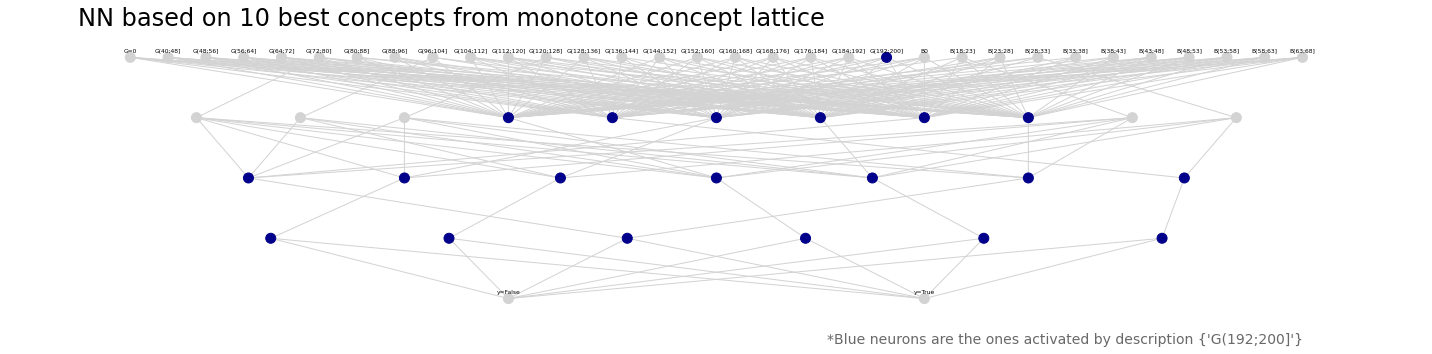

In [70]:
fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))
                ],
               node_size=100,
               node_label_font_size=6
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_more_concepts.png')
plt.show()

Now fit the network

5 000 epochs

In [64]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [65]:
cn.fit(X_train, y_train,  n_epochs = 5000)

In [66]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [1 0 0 0 0 0 0 1 0 0]
Class prediction with probabilities [[5.83962844e-07 9.99999404e-01]
 [9.99721825e-01 2.78201711e-04]
 [9.99994159e-01 5.88906732e-06]
 [5.00192404e-01 4.99807566e-01]
 [1.00000000e+00 1.19868435e-08]
 [1.00000000e+00 2.46948719e-08]
 [5.37704110e-01 4.62295890e-01]
 [6.39339032e-06 9.99993563e-01]
 [9.99996901e-01 3.11991721e-06]
 [9.99843717e-01 1.56288748e-04]]
True class [ True False False  True False False  True  True False False]


In [67]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Recall score: 0.4189189189189189
F1     score: 0.5081967213114754
Accuracy score: 0.7402597402597403


In [72]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000)
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[3.8763341e-02 9.6123660e-01]
 [9.8837668e-01 1.1623343e-02]
 [9.9993110e-01 6.8873516e-05]
 [4.5431432e-01 5.4568565e-01]
 [9.9999452e-01 5.4421221e-06]
 [9.9996972e-01 3.0304145e-05]
 [3.8763341e-02 9.6123660e-01]
 [3.8763341e-02 9.6123660e-01]
 [9.9996066e-01 3.9343187e-05]
 [9.9723417e-01 2.7658779e-03]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.4594594594594595
F1     score: 0.5396825396825398
Accuracy score: 0.7489177489177489


This is the best so far $\downarrow$

In [77]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000)
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[4.0502610e-04 9.9959499e-01]
 [9.8086995e-01 1.9130012e-02]
 [9.9997497e-01 2.5032388e-05]
 [4.9823141e-01 5.0176865e-01]
 [9.9998164e-01 1.8353672e-05]
 [9.9996769e-01 3.2305263e-05]
 [1.7246695e-06 9.9999833e-01]
 [4.5307488e-06 9.9999547e-01]
 [9.9947125e-01 5.2881299e-04]
 [9.9604493e-01 3.9550164e-03]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.527027027027027
F1     score: 0.5864661654135338
Accuracy score: 0.7619047619047619


In [74]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000)
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 0 0 0 0 0 0 0]
Class prediction with probabilities [[0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]
 [0.78493613 0.21506388]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.0
F1     score: 0.0
Accuracy score: 0.6796536796536796


This is for 2 000 epochs with F1 0.58

In [78]:
edge_weights = cn.edge_weights_from_network()

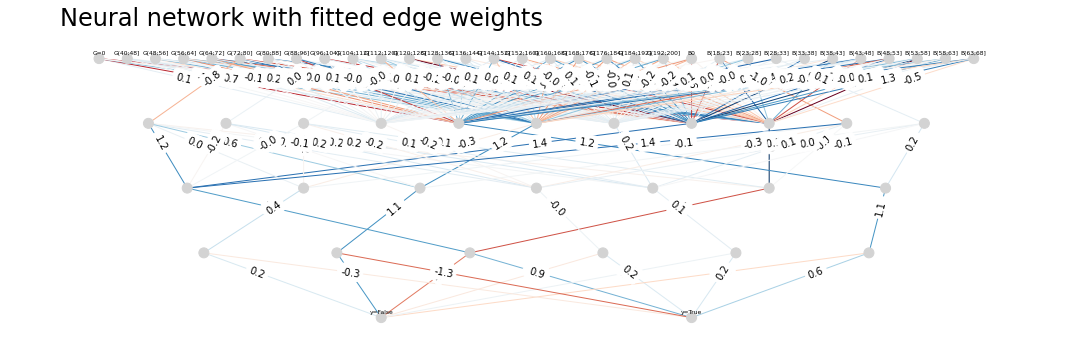

In [79]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_more_concepts.png')
plt.show()